In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset



In [2]:
%store -r x_train
%store -r y_train
%store -r x_valid
%store -r y_valid
%store -r x_test
%store -r y_test

# Model 1: Simple 1DCNN

Our first model will be a simple 1D CNN model, without the use of any metadata as features, other than the ECG signal itself. This model will be used as a baseline to compare against more complex models that incorporate additional features.

In [32]:
meta_features = ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device']
meta_features.append('strat_fold') # will not be used for cross-validation in train set

x_train = x_train
x_valid = x_valid
x_test = x_test
x_meta_train = y_train[meta_features]
x_meta_valid = y_valid[meta_features]
x_meta_test = y_test[meta_features]
y_train = y_train.drop(columns=meta_features)
y_valid = y_valid.drop(columns=meta_features)
y_test = y_test.drop(columns=meta_features)

KeyError: "None of [Index(['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device',\n       'strat_fold'],\n      dtype='object')] are in the [columns]"

In [14]:
y_train.columns

Index(['NORM', 'MI', 'STTC', 'HYP', 'CD', 'sub_NORM', 'sub_IMI', 'sub_STTC',
       'sub_NST_', 'sub_LVH', 'sub_LAFB/LPFB', 'sub_RVH', 'sub_IRBBB',
       'sub_RAO/RAE', 'sub_IVCD', 'sub_LMI', 'sub_AMI', 'sub__AVB', 'sub_ISCA',
       'sub_ISC_', 'sub_SEHYP', 'sub_ISCI', 'sub_CRBBB', 'sub_CLBBB',
       'sub_LAO/LAE', 'sub_ILBBB', 'sub_WPW', 'sub_PMI'],
      dtype='object')

### Normalize/standardize

In [18]:
print('x_train shape:', x_train.shape)

x_train shape: (17441, 1000, 12)


In [ ]:
# Standardize the features across all 12 channels
num_channels = x_train.shape[2] # 12

x_train = np.empty_like(x_train)
x_valid = np.empty_like(x_valid)
x_test = np.empty_like(x_test)

scalers = []
for ch in range(num_channels):
    scaler = StandardScaler()
    x_train[:, :, ch] = scaler.fit_transform(x_train[:, :, ch])
    x_valid[:, :, ch] = scaler.transform(x_valid[:, :, ch])
    x_test[:, :, ch] = scaler.transform(x_test[:, :, ch])
    scalers.append(scaler)


In [ ]:
#for i, scaler in enumerate(scalers):
#    print(f"Channel {i}: mean={scaler.mean_[0]:.4f}, std={scaler.scale_[0]:.4f}")

In [24]:
class ECG1DCNN(nn.Module):
    def __init__(self, num_features, num_labels):
        super(ECG1DCNN, self).__init__()
        
        # CNN for ECG signal (12 leads)
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.AdaptiveAvgPool1d(1)  # Output shape: (batch, 128, 1)

        # MLP for tabular features
        self.tabular_net = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, num_labels),
            nn.Sigmoid()  # for multilabel
        )

    def forward(self, ecg, tabular):
        # ECG branch
        x = F.relu(self.bn1(self.conv1(ecg)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)  # flatten

        # Tabular branch
        t = self.tabular_net(tabular)

        # Concatenate & classify
        combined = torch.cat((x, t), dim=1)
        out = self.classifier(combined)
        return out

In [25]:
def train_model_selection(model, loaders, optimizer, criterion, epochs=10, dev=torch.device('cpu'), checkpoint_path='best_model.pt'):
    model = model.to(dev)
    best_val_loss = float('inf')
    history_loss = {'train': [], 'val': []}
    history_acc = {'train': [], 'val': []}

    for epoch in range(epochs):
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, corrects, total = 0.0, 0, 0

            for ecg, tabular, labels in loaders[phase]:
                ecg, tabular, labels = ecg.to(dev), tabular.to(dev), labels.to(dev)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(ecg, tabular)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * ecg.size(0)
                preds = (outputs > 0.5).float()
                corrects += (preds == labels).sum().item()
                total += labels.numel()

            epoch_loss = running_loss / len(loaders[phase].dataset)
            epoch_acc = corrects / total
            history_loss[phase].append(epoch_loss)
            history_acc[phase].append(epoch_acc)

            print(f"[{epoch+1}/{epochs}] {phase.upper()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

    return history_loss, history_acc

In [29]:
from helpers import to_tensor

num_features = x_train.shape[1]
num_labels = y_train.shape[1]

model = ECG1DCNN(num_features=num_features, num_labels=num_labels)

# Loss and optimizer
criterion = nn.BCELoss()  # For multilabel classification with sigmoid
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = TensorDataset(to_tensor(x_train), to_tensor(y_train))
valid_ds = TensorDataset(to_tensor(x_valid), to_tensor(y_valid))
test_ds = TensorDataset(to_tensor(x_test), to_tensor(y_test))

# Dataloaders
loaders = {
    "train": DataLoader(train_ds, batch_size=64, shuffle=True),
    "val":   DataLoader(valid_ds, batch_size=64),
    "test":  DataLoader(test_ds, batch_size=64)
}

In [30]:
def train_model_selection(model, loaders, optimizer, criterion, epochs=10, dev=torch.device('cpu'), checkpoint_path='./ecg_best_model.pt'):
    best_val_loss = float('inf')
    print(f"Training on device: {dev}")
    print(f"Saving best model checkpoint to: {checkpoint_path}")
    try:
        model = model.to(dev)
        print(model)

        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}

        for epoch in range(epochs):
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}

            for split in ["train", "val", "test"]:
                if not loaders.get(split):
                    print(f"Skipping {split} phase for epoch {epoch+1} due to empty loader.")
                    history_loss[split].append(float('nan'))
                    history_accuracy[split].append(float('nan'))
                    continue

                model.train() if split == "train" else model.eval()

                for ecg, tabular, labels in loaders[split]:
                    ecg = ecg.permute(0, 2, 1).to(dev) 
                    tabular = tabular.to(dev)
                    labels = labels.to(dev)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(split == "train"):
                        outputs = model(ecg, tabular)
                        loss = criterion(outputs, labels)
                        if split == "train":
                            loss.backward()
                            optimizer.step()

                    sum_loss[split] += loss.item()
                    preds = (outputs > 0.5).float()
                    batch_acc = (preds == labels).sum().item() / labels.numel()
                    sum_accuracy[split] += batch_acc

            # Average epoch metrics
            epoch_loss = {s: (sum_loss[s] / len(loaders[s]) if loaders.get(s) else float('nan')) for s in ["train", "val", "test"]}
            epoch_acc = {s: (sum_accuracy[s] / len(loaders[s]) if loaders.get(s) else float('nan')) for s in ["train", "val", "test"]}

            # Save best model
            if loaders.get("val") and epoch_loss["val"] < best_val_loss:
                best_val_loss = epoch_loss["val"]
                torch.save({
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": epoch_loss["val"]
                }, checkpoint_path)
                print(f"Epoch {epoch+1}: ✅ Saved best model with Val_Loss: {best_val_loss:.4f}")

            # Store history
            for s in ["train", "val", "test"]:
                history_loss[s].append(epoch_loss[s])
                history_accuracy[s].append(epoch_acc[s])

            # Print epoch summary
            print(f"Epoch {epoch+1}/{epochs}:",
                  f"Train Loss={epoch_loss['train']:.4f}," if loaders.get('train') else "TrL=N/A,",
                  f"Train Accuracy={epoch_acc['train']:.4f}," if loaders.get('train') else "TrA=N/A,",
                  f"Val Loss={epoch_loss['val']:.4f}," if loaders.get('val') else "VL=N/A,",
                  f"Val Accuracy={epoch_acc['val']:.4f}," if loaders.get('val') else "VA=N/A,",
                  f"Test Loss={epoch_loss['test']:.4f}," if loaders.get('test') else "TeL=N/A,",
                  f"Test Accuracy={epoch_acc['test']:.4f}" if loaders.get('test') else "TeA=N/A")

    except KeyboardInterrupt:
        print("Training interrupted manually.")

    finally:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            if loaders.get(split): plt.plot(history_loss[split], label=split)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            if loaders.get(split): plt.plot(history_accuracy[split], label=split)
        plt.legend()

        plt.tight_layout()
        plt.show()

Training on device: cpu
Saving best model checkpoint to: ./ecg_best_model.pt
ECG1DCNN(
  (conv1): Conv1d(12, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): AdaptiveAvgPool1d(output_size=1)
  (tabular_net): Sequential(
    (0): Linear(in_features=1000, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(

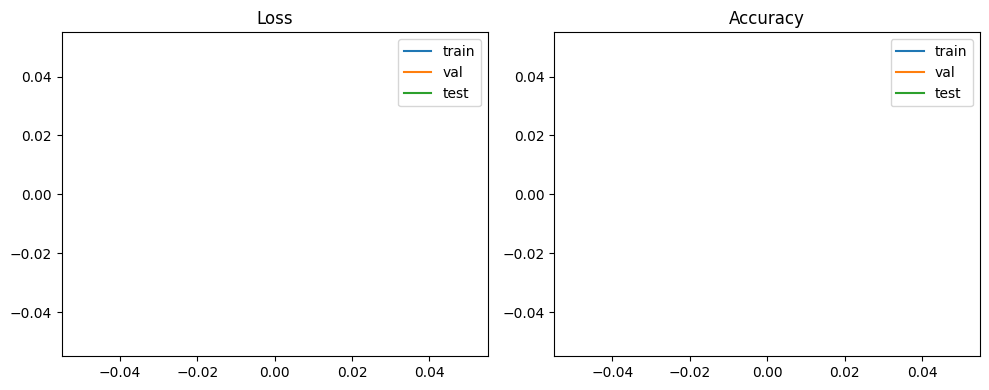

ValueError: not enough values to unpack (expected 3, got 2)

In [31]:
train_model_selection(
    model,
    loaders=loaders,
    optimizer=optimizer,
    criterion=criterion,
    epochs=10,
    dev=device,
    checkpoint_path="./ecg_best_model.pt"
)